# Quantum Neural Networks

In [1]:
import pandas as pd
from IPython.core.display_functions import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
import matplotlib.pyplot as plt

## Provide configuration options for the learning process
---

In [142]:
RANDOM_SEED = 42
SHOTS = 1024
FEATURES = 4
OUTPUT_SHAPE = 2
TRAIN_DATA_SPLIT = 0.75
objective_func_vals = []

## Prepare and analyze dataset
---

In [143]:
df = pd.read_csv('datasets/vlds.csv', index_col=0)
df.count()

feature_1    500
feature_2    500
feature_3    500
feature_4    500
label        500
dtype: int64

In [144]:
df.head(5)

,feature_1,feature_2,feature_3,feature_4,label
0,7.0,19.0,9.0,8.0,1.0
1,8.0,22.0,15.0,4.0,1.0
2,5.0,26.0,19.0,14.0,1.0
3,7.0,10.0,16.0,16.0,0.0
4,7.0,16.0,4.0,8.0,0.0


In [145]:
print(f'Rows with label = 1: #{df.where(df["label"] == 1.0)["label"].count()}')
print(f'Rows with label = 0: #{df.where(df["label"] == 0.0)["label"].count()}')

Rows with label = 1: #323
Rows with label = 0: #177


In [146]:
train = df.sample(frac=TRAIN_DATA_SPLIT, random_state=RANDOM_SEED)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Setup quantum circuit
---

In [147]:
algorithm_globals.random_seed = RANDOM_SEED
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=SHOTS)

feature_map = ZZFeatureMap(feature_dimension=FEATURES)
ansatz = RealAmplitudes(FEATURES)
qc = QuantumCircuit(FEATURES)
qc.append(feature_map, range(FEATURES))
qc.append(ansatz, range(FEATURES))
qc.decompose().draw(output='mpl')
plt.show()

In [148]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=OUTPUT_SHAPE,
    interpret=parity,
)

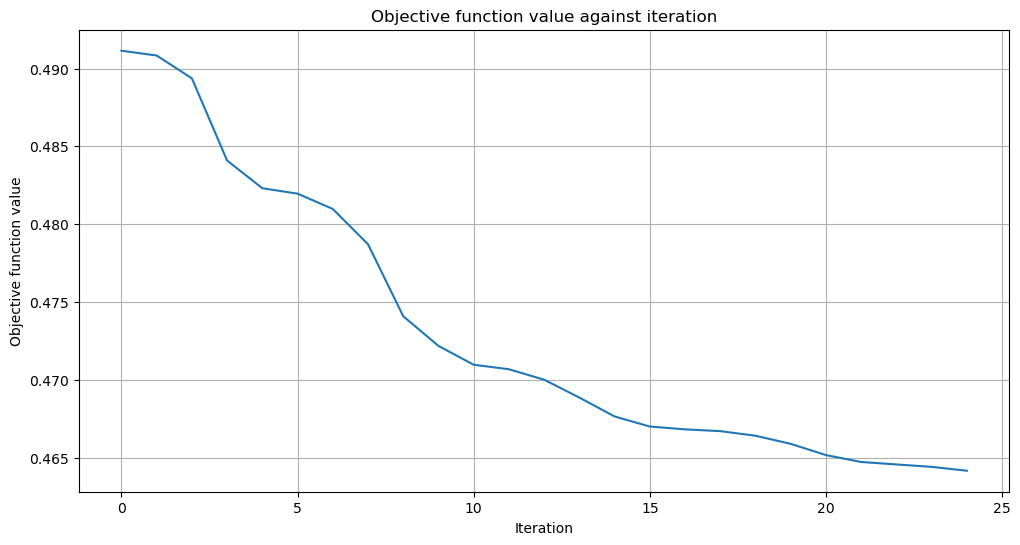

In [149]:
def callback_graph(_weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    # optimizer=ADAM(maxiter=500),
    optimizer=SLSQP(maxiter=25),
    callback=callback_graph
)

# Train the model
plt.rcParams["figure.figsize"] = (12, 6)
sampler_classifier.fit(train_features, train_labels)

In [150]:
score = sampler_classifier.score(test_features, test_labels)
print(f"Accuracy: {score}")

Accuracy: 0.528
